In [311]:
import os
import gc
from tqdm import tqdm
import glob
import random
import pandas as pd
import numpy as np
import sklearn
import math
import matplotlib.pyplot as plt
import prophet
import pdb
import datetime
from scipy import interpolate
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchinfo import summary
from torch.utils.data import DataLoader, Dataset

In [312]:
print('pandas ver : ' + pd.__version__)
print('numpy ver : ' + np.__version__)
print('sklearn ver : ' + sklearn.__version__)
print('prophet ver :' + prophet.__version__)

pandas ver : 1.5.3
numpy ver : 1.23.2
sklearn ver : 1.2.2
prophet ver :1.13.1


In [237]:
INPUT_TIMESTEP = 48
OUTPUT_TIMESTEP = 72
TEACHER_FORCING_RATIO = 0.5
EPOCHS = 50
LR = 1e-3
BS = 64
SEED = 42
MODEL_NAME ='LSTM_Seq2Seq'
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed_everything(SEED) # Seed 고정

In [238]:
device = torch.device('cpu') if torch.backends.mps.is_available() else torch.device('cpu')
torch.autograd.set_detect_anomaly(False)
print(device)

cpu


# AWSmap pmmap

In [239]:
awsmap = pd.read_csv('./data/META/awsmap.csv')
pmmap = pd.read_csv('./data/META/pmmap.csv')

In [240]:
pmmap

,Location,Latitude,Longitude,Description
0,아름동,36.512252,127.246789,세종특별자치시 보듬3로 114 아름동커뮤니티센터 옥상 (아름동)
1,신흥동,36.592887,127.292550,세종 조치원읍 군청로 87-16(신흥동) 세종특별자치시 조치원청사 옥상
2,노은동,36.368242,127.318498,대전 유성구 노은동로 87번길 89(노은1동 주민센터) 노은1동 주민센터 3층 옥상
3,문창동,36.317215,127.437825,대전 중구 보문로 20번길 38(문창동 주민센터) 문창동 주민센터
4,읍내동,36.372388,127.417714,대전 대덕구 대전로 1331번길 75(태아산업(주)) 태아산업(주)
5,정림동,36.304442,127.366742,대전 서구 정림동로 10(정림동 주민센터) 정림동 주민센터
6,공주,36.446951,127.119209,충남 공주시 봉황로 1 (공주시의회 옥상)
7,논산,36.199217,127.087021,충남 논산시 시민로 389 (취암/부창동 행정복지센터 2층 옥상)
8,대천2동,36.353148,126.589735,충남 보령시 중앙로 142-16 (대천2동 주민센터 옥상)
9,독곶리,36.987579,126.391672,충남 서산시 대산읍 평신1로(독곶리) 한국수자원공사 대산산업용수센터 저수동 옥상


In [241]:
awsmap

,Location,Latitude,Longitude,Description
0,오월드,36.2913,127.3959,대전광역시 중구사정공원로 70 오월드 내 플라워랜드
1,세천,36.3402,127.4938,대전광역시 동구세천동 63-1
2,장동,36.4135,127.4382,대전광역시 대덕구장동 360-2
3,세종고운,36.5315,127.2406,세종특별자치시 고운동산 25번지
4,세종금남,36.4585,127.2688,세종특별자치시 시군구금남면 성덕리 77-3
5,세종연서,36.5667,127.2806,세종특별자치시 연서면봉암리 196-1
6,세종전의,36.6908,127.2005,세종특별자치시 전의면읍내리 5-1번지(전의생활체육공원)
7,북격렬비도,36.6254,125.5595,충청남도 태안군근흥면 가의도리산 27(북격렬비도)
8,호도,36.3012,126.2663,충청남도 보령시오천면 녹도리 388-5
9,대산,37.0106,126.3881,충청남도 서산시대산읍 대죽리산95-1 (5304부대 대산방공진지)


## Scatter plot

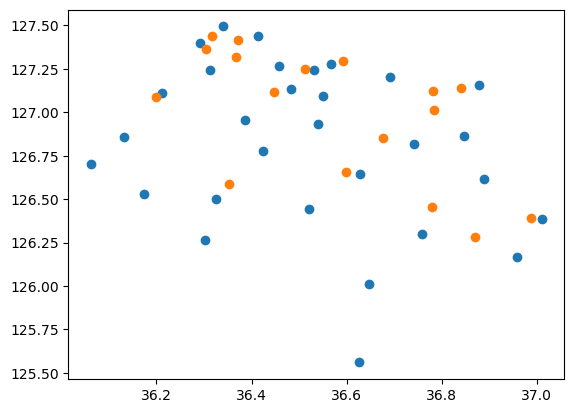

In [242]:
plt.scatter(awsmap['Latitude'], awsmap['Longitude'])
plt.scatter(pmmap['Latitude'], pmmap['Longitude'])
plt.show()

## Calculate distance

In [243]:
pm_cood = pmmap[['Location','Latitude','Longitude']]
aws_cood = awsmap[['Location','Latitude','Longitude']]

In [244]:
distance_list = []
location_list = []
for i in range(len(pm_cood)):
    min_distance = 1000000000
    location = None
    pm_lat = pm_cood['Latitude'][i]
    pm_lon = pm_cood['Longitude'][i]
    for j in range(len(aws_cood)):
        aws_lat = aws_cood['Latitude'][j]
        aws_lon = aws_cood['Longitude'][j]
        distance = math.sqrt((pm_lat-aws_lat)**2 + (pm_lon-aws_lon)**2)
        if min_distance > distance:
            min_distance = distance
            location = aws_cood['Location'][j]
    distance_list.append(min_distance)
    location_list.append(location)

In [245]:
print(location_list)

['세종고운', '세종연서', '계룡', '오월드', '장동', '오월드', '공주', '논산', '대천항', '대산', '태안', '아산', '성거', '예산', '태안', '홍북', '성거']


# Concatenate PM and AWS

In [246]:
pm_csv_list = sorted(glob.glob('./data/TRAIN/*'))
pm_csv_list

['./data/TRAIN/공주.csv',
 './data/TRAIN/노은동.csv',
 './data/TRAIN/논산.csv',
 './data/TRAIN/대천2동.csv',
 './data/TRAIN/독곶리.csv',
 './data/TRAIN/동문동.csv',
 './data/TRAIN/모종동.csv',
 './data/TRAIN/문창동.csv',
 './data/TRAIN/성성동.csv',
 './data/TRAIN/신방동.csv',
 './data/TRAIN/신흥동.csv',
 './data/TRAIN/아름동.csv',
 './data/TRAIN/예산군.csv',
 './data/TRAIN/읍내동.csv',
 './data/TRAIN/이원면.csv',
 './data/TRAIN/정림동.csv',
 './data/TRAIN/홍성읍.csv']

In [310]:
aws_basepath = './data/TRAIN_AWS/'
data = []
for idx, pm_path in enumerate(pm_csv_list):
    aws_path = './data/TRAIN_AWS/'+location_list[idx]+'.csv'
    pm_data = pd.read_csv(pm_path)
    aws_data = pd.read_csv(aws_path)
    #print(pm_data)
    #print(aws_data)
    aws_data['PM2.5'] = pm_data['PM2.5']
    time = []
    for i in range(len(aws_data)):
        time.append(datetime.datetime(2010+aws_data['연도'][i], int(aws_data['일시'][0][0:2]), 
                                             int(aws_data['일시'][i][3:5]), int(aws_data['일시'][i][6:8]), int(aws_data['일시'][i][9:])))
    aws_data['time'] = time
    aws_data['기온(°C)'].interpolate(method='cubic', inplace=True)
    aws_data['풍향(deg)'].interpolate(method='cubic', inplace=True)
    aws_data['풍속(m/s)'].interpolate(method='cubic', inplace=True)
    aws_data['강수량(mm)'].interpolate(method='cubic', inplace=True)
    aws_data['습도(%)'].interpolate(method='cubic', inplace=True)
    aws_data['PM2.5'].interpolate(method='cubic', inplace=True)
    
    aws_data.dropna(axis=0,inplace=True)
    
    aws_data.drop(['연도', '일시', '지점'], axis=1, inplace=True)
    
    
    aws_data = aws_data[['time','기온(°C)','풍향(deg)','풍속(m/s)','강수량(mm)','습도(%)','PM2.5']]
    #print(aws_data.describe())
    data.append(aws_data)

    #print(aws_data)

             기온(°C)       풍향(deg)       풍속(m/s)       강수량(mm)         습도(%)  \
count  35064.000000  35064.000000  35064.000000  35064.000000  35064.000000   
mean       0.579297      0.391206      0.035396      0.001782      0.696283   
std        0.164991      0.325173      0.028738      0.014081      0.219401   
min        0.083728     -2.177995     -0.052748     -0.005819      0.043000   
25%        0.448657      0.092778      0.015345      0.000000      0.537000   
50%        0.589258      0.341111      0.028133      0.000000      0.719000   
75%        0.715640      0.674167      0.051151      0.000000      0.894000   
max        0.962085      2.517574      0.255754      0.664773      1.010447   

              PM2.5  
count  35064.000000  
mean       0.088991  
std        0.082388  
min       -0.481412  
25%        0.040000  
50%        0.072000  
75%        0.116000  
max        0.975856  
             기온(°C)       풍향(deg)       풍속(m/s)       강수량(mm)         습도(%)  \
count  3506

             기온(°C)       풍향(deg)       풍속(m/s)       강수량(mm)         습도(%)  \
count  35064.000000  35064.000000  35064.000000  35064.000000  35064.000000   
mean       0.582408      0.459512      0.044323      0.002200      0.744164   
std        0.156068      0.353669      0.033624      0.024221      0.183943   
min        0.115324     -2.819169     -0.100162     -0.029386     -0.125984   
25%        0.456556      0.143611      0.017903      0.000000      0.614000   
50%        0.587678      0.429128      0.040921      0.000000      0.766000   
75%        0.714060      0.819722      0.063939      0.000000      0.911000   
max        1.009305      2.929611      0.347826      0.864605      1.372953   

              PM2.5  
count  35064.000000  
mean       0.090561  
std        0.086503  
min       -0.603855  
25%        0.036000  
50%        0.072000  
75%        0.124000  
max        0.950655  
             기온(°C)       풍향(deg)       풍속(m/s)       강수량(mm)         습도(%)  \
count  3506

In [252]:
for i in range(len(data)):
    print(data[i].isnull().sum())

time       0
기온(°C)     0
풍향(deg)    0
풍속(m/s)    0
강수량(mm)    0
습도(%)      0
PM2.5      0
dtype: int64
time       0
기온(°C)     0
풍향(deg)    0
풍속(m/s)    0
강수량(mm)    0
습도(%)      0
PM2.5      0
dtype: int64
time       0
기온(°C)     0
풍향(deg)    0
풍속(m/s)    0
강수량(mm)    0
습도(%)      0
PM2.5      0
dtype: int64
time       0
기온(°C)     0
풍향(deg)    0
풍속(m/s)    0
강수량(mm)    0
습도(%)      0
PM2.5      0
dtype: int64
time       0
기온(°C)     0
풍향(deg)    0
풍속(m/s)    0
강수량(mm)    0
습도(%)      0
PM2.5      0
dtype: int64
time       0
기온(°C)     0
풍향(deg)    0
풍속(m/s)    0
강수량(mm)    0
습도(%)      0
PM2.5      0
dtype: int64
time       0
기온(°C)     0
풍향(deg)    0
풍속(m/s)    0
강수량(mm)    0
습도(%)      0
PM2.5      0
dtype: int64
time       0
기온(°C)     0
풍향(deg)    0
풍속(m/s)    0
강수량(mm)    0
습도(%)      0
PM2.5      0
dtype: int64
time       0
기온(°C)     0
풍향(deg)    0
풍속(m/s)    0
강수량(mm)    0
습도(%)      0
PM2.5      0
dtype: int64
time       0
기온(°C)     0
풍향(deg)    0
풍속(m/s)    0
강수량(mm)    0

In [253]:
def make_3d(df):
    df = df.drop('time',axis=1)
    train_x = []
    train_y = []
    val_x = []
    val_y = []
    for i in range(len(df)-INPUT_TIMESTEP-OUTPUT_TIMESTEP+1):
        if i < 30000:
            train_x.append(np.array((df[:][i:i+INPUT_TIMESTEP])))
            #print("X")
            #print(df[:][i:i+INPUT_TIMESTEP])
            train_y.append(np.array(df['PM2.5'][i+INPUT_TIMESTEP:i+INPUT_TIMESTEP+OUTPUT_TIMESTEP]))
            #print("Y")
            #print(df['PM2.5'][i+INPUT_TIMESTEP:i+INPUT_TIMESTEP+OUTPUT_TIMESTEP])
        else:
            val_x.append(np.array((df[:][i:i+INPUT_TIMESTEP])))
            #print("X")
            #print(df[:][i:i+INPUT_TIMESTEP])
            val_y.append(np.array(df['PM2.5'][i+INPUT_TIMESTEP:i+INPUT_TIMESTEP+OUTPUT_TIMESTEP]))
    return train_x, train_y, val_x, val_y

In [254]:
train_x_before_tensor = []
train_y_before_tensor = []
val_x_before_tensor = []
val_y_before_tensor = []
for i in range(len(data)):
    train_x, train_y, val_x, val_y = make_3d(data[i])
    train_x_before_tensor.extend(train_x)
    train_y_before_tensor.extend(train_y)
    val_x_before_tensor.extend(val_x)
    val_y_before_tensor.extend(val_y)

In [255]:
len(train_x_before_tensor)

510000

In [256]:
train_x_tensor = torch.tensor(train_x_before_tensor)
train_y_tensor = torch.tensor(train_y_before_tensor).reshape(-1,OUTPUT_TIMESTEP,1)
val_x_tensor = torch.tensor(val_x_before_tensor)
val_y_tensor = torch.tensor(val_y_before_tensor).reshape(-1,OUTPUT_TIMESTEP,1)
print(train_x_tensor.shape)
print(train_y_tensor.shape)
print(val_x_tensor.shape)
print(val_y_tensor.shape)

torch.Size([510000, 48, 6])
torch.Size([510000, 72, 1])
torch.Size([84042, 48, 6])
torch.Size([84042, 72, 1])


In [257]:
class MyDataset(Dataset):
    def __init__(self, origin_x, origin_y):
        self.data = origin_x
        self.target = origin_y
        
    def __getitem__(self, index):
        self.x = self.data[index]
        self.y = self.target[index]
        return self.x, self.y

    def __len__(self):
        return len(self.data)

#Pytorch를 사용하기 위해 custom dataset 구성해줌

In [258]:
train_dataset = MyDataset(train_x_tensor, train_y_tensor)
train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=False)
val_dataset = MyDataset(val_x_tensor, val_y_tensor)
val_loader = DataLoader(val_dataset, batch_size=BS, shuffle=False)

In [259]:
it = iter(train_loader)
print(next(it)[0].shape)
print(next(it)[1].shape)
input_size = next(it)[0].shape[2]

torch.Size([64, 48, 6])
torch.Size([64, 72, 1])


In [260]:
#Reference : https://doheon.github.io/%EC%BD%94%EB%93%9C%EA%B5%AC%ED%98%84/time-series/ci-3.lstm-post/
class Encoder(nn.Module):
    def __init__(self, input_size):
        super(Encoder, self).__init__()
        self.input_size = input_size
        self.lstm = nn.LSTM(input_size = input_size, hidden_size = 128, num_layers = 1, batch_first=True)
        self.weight_init()
        
    def forward(self, x):
        output, hidden = self.lstm(x)
        return output, hidden
    
    def weight_init(self):
        #Reference : https://www.kaggle.com/code/junkoda/pytorch-lstm-with-tensorflow-like-initialization
        """
        Tensorflow/Keras-like initialization
        """
        for name, p in self.named_parameters():
            if 'lstm' in name:
                if 'weight_ih' in name:
                    nn.init.xavier_uniform_(p.data)
                elif 'weight_hh' in name:
                    nn.init.orthogonal_(p.data)
                elif 'bias_ih' in name:
                    p.data.fill_(0)
                    # Set forget-gate bias to 1
                    n = p.size(0)
                    p.data[(n // 4):(n // 2)].fill_(1)
                elif 'bias_hh' in name:
                    p.data.fill_(0)
                    
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal(m.weight)
                nn.init.zeros_(m.bias)

In [265]:
class Decoder(nn.Module):
    def __init__(self, input_size):
        super(Decoder, self).__init__()
        self.input_size = input_size
        self.lstm = nn.LSTM(input_size = 1, hidden_size = 128, num_layers = 1, batch_first=True)
        self.linear = nn.Linear(128, 1)           
        self.weight_init()
        
    def forward(self, x, encoder_hidden_states):
        x = x.unsqueeze(1)
        #print(x.shape)
        lstm_out, hidden = self.lstm(x, encoder_hidden_states)
        output = self.linear(lstm_out)
        
        
        return output, hidden
    
    def weight_init(self):
        #Reference : https://www.kaggle.com/code/junkoda/pytorch-lstm-with-tensorflow-like-initialization
        """
        Tensorflow/Keras-like initialization
        """
        for name, p in self.named_parameters():
            if 'lstm' in name:
                if 'weight_ih' in name:
                    nn.init.xavier_uniform_(p.data)
                elif 'weight_hh' in name:
                    nn.init.orthogonal_(p.data)
                elif 'bias_ih' in name:
                    p.data.fill_(0)
                    # Set forget-gate bias to 1
                    n = p.size(0)
                    p.data[(n // 4):(n // 2)].fill_(1)
                elif 'bias_hh' in name:
                    p.data.fill_(0)
                    
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal(m.weight)
                nn.init.zeros_(m.bias)

In [266]:
class Seq2Seq_model(nn.Module):
    def __init__(self, input_size):
        super(Seq2Seq_model, self).__init__()

        self.input_size = input_size

        self.encoder = Encoder(input_size = input_size)
        self.decoder = Decoder(input_size = input_size)

    def forward(self, x, y):
        batch_size = x.shape[0]
        input_size = x.shape[2]

        outputs = torch.zeros(batch_size, OUTPUT_TIMESTEP,1).to(device)

        _, hidden = self.encoder(x)
        decoder_input = x[:,-1, -1]
        decoder_input = decoder_input.unsqueeze(-1)
        
        for t in range(OUTPUT_TIMESTEP): 
            #print("Decoder Input : "+str(decoder_input.shape))
            out, hidden = self.decoder(decoder_input, hidden)
            #print("out shape : "+ str(out.shape))
            out =  out.squeeze(1)
            #print("out shape after squeeze: "+ str(out.shape))
            if random.random() < TEACHER_FORCING_RATIO:
                decoder_input = y[:, t, :]
            else:
                decoder_input = out
            outputs[:,t,:] = out
            #print(outputs.shape)

        return outputs
    
    def predict(self, x):
        batch_size = x.shape[0]
        input_size = x.shape[2]

        outputs = torch.zeros(batch_size, OUTPUT_TIMESTEP,1)

        _, hidden = self.encoder(x)
        decoder_input = x[:,-1, -1]
        decoder_input = decoder_input.unsqueeze(-1)
        
        for t in range(OUTPUT_TIMESTEP): 
            #print("Decoder Input : "+str(decoder_input.shape))
            out, hidden = self.decoder(decoder_input, hidden)
            #print("out shape : "+ str(out.shape))
            out =  out.squeeze(1)
            #print("out shape after squeeze: "+ str(out.shape))
            decoder_input = out
            outputs[:,t,:] = out
            #print(outputs.shape)

        return outputs
    

In [267]:
class Trainer():
    def __init__(self, model, optimizer, train_loader, val_loader, scheduler, device):
        self.model = model
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.scheduler = scheduler
        self.device = device
        # Loss Function
        self.criterion = nn.MSELoss().to(self.device)
        
    def fit(self):
        self.model.to(self.device)
        best_loss = 1000000000
        for epoch in range(EPOCHS):
            self.model.train()
            train_loss = []
            i = 1
            for x, y in tqdm(self.train_loader):
                x = x.float().to(self.device)
                y = y.float().to(self.device)
                self.optimizer.zero_grad()
                output = self.model(x, y).to(device)
                output = output.squeeze(-1)
                y = y.squeeze(-1)
                torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
                loss = self.criterion(y,output)
                loss.backward()
                self.optimizer.step()
                train_loss.append(loss.item())
                i=i+1
                
            val_loss = self.validation(self.model)
            
            mean_train_loss = np.mean(train_loss)
            
            print(f'Epoch : [{epoch+1}] Train loss : [{mean_train_loss}]\nVal Loss : [{val_loss}]\n')
            
            self.scheduler.step(val_loss)
            
            if best_loss > val_loss:
                best_loss = val_loss
                torch.save(self.model, './' + MODEL_NAME+'.pth')
                print("Save Model~_~")
                
        print(best_loss)
           
    def validation(self, eval_model):
        eval_model.eval()
        val_loss = []
        mse_list = []
        with torch.no_grad():
            for x, y in iter(self.val_loader):
                x = x.float().to(self.device)
                y = y.float().to(self.device)
                output = eval_model.predict(x)
                output = output.squeeze(-1)
                y = y.squeeze(-1)
                loss = self.criterion(y,output)
                val_loss.append(loss.item())
                
        return np.mean(val_loss)

In [268]:
#Train model
gc.collect()

seed_everything(SEED)
model = Seq2Seq_model(input_size).to(device)
#Using AdamW Optimizer
optimizer = torch.optim.AdamW(params = model.parameters(), lr = LR,weight_decay=1e-1)#Opimizer : AdamW
#Using Learning Rate Scheduler (ReduceLROnPlateau)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=20, threshold = 1e-8, threshold_mode='abs', min_lr=1e-8, verbose=True)
trainer = Trainer(model, optimizer, train_loader, val_loader, scheduler, device)
#trainer 객체 생성
trainer.fit()

/var/folders/wh/7nbvd7tj6j99g3z6knc92ccc0000gn/T/ipykernel_28561/1272543324.py:39: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight)
100%|███████████████████████████████████████| 7969/7969 [09:17<00:00, 14.30it/s]


Epoch : [1] Train loss : [0.0030332824102041267]
Val Loss : [0.004706514873231362]



100%|███████████████████████████████████████| 7969/7969 [09:17<00:00, 14.30it/s]


Epoch : [2] Train loss : [0.006122978756605437]
Val Loss : [0.0038102054530368408]



100%|███████████████████████████████████████| 7969/7969 [09:15<00:00, 14.34it/s]


Epoch : [3] Train loss : [0.004168658587617383]
Val Loss : [0.003810718909635661]



100%|███████████████████████████████████████| 7969/7969 [09:21<00:00, 14.19it/s]


Epoch : [4] Train loss : [0.0029366660626531315]
Val Loss : [0.0037996082430927095]



100%|███████████████████████████████████████| 7969/7969 [09:21<00:00, 14.18it/s]


Epoch : [5] Train loss : [0.004542695991592887]
Val Loss : [0.0038048125184693055]



100%|███████████████████████████████████████| 7969/7969 [09:22<00:00, 14.17it/s]


Epoch : [6] Train loss : [0.007379403934380791]
Val Loss : [0.004341077008033016]



 15%|█████▋                                 | 1168/7969 [01:22<07:53, 14.36it/s]

In [272]:
pretrained_model = torch.load('./' + MODEL_NAME+'.pth')
pretrained_model = pretrained_model.to(device)
pretrained_model.eval()
summary(pretrained_model)

Layer (type:depth-idx)                   Param #
Seq2Seq_model                            --
├─Encoder: 1-1                           --
│    └─LSTM: 2-1                         69,632
├─Decoder: 1-2                           --
│    └─LSTM: 2-2                         67,072
│    └─Linear: 2-3                       129
Total params: 136,833
Trainable params: 136,833
Non-trainable params: 0

In [273]:
test_pm_csv_list = sorted(glob.glob('./data/TEST_INPUT/*'))
test_pm_csv_list

['./data/TEST_INPUT/공주.csv',
 './data/TEST_INPUT/노은동.csv',
 './data/TEST_INPUT/논산.csv',
 './data/TEST_INPUT/대천2동.csv',
 './data/TEST_INPUT/독곶리.csv',
 './data/TEST_INPUT/동문동.csv',
 './data/TEST_INPUT/모종동.csv',
 './data/TEST_INPUT/문창동.csv',
 './data/TEST_INPUT/성성동.csv',
 './data/TEST_INPUT/신방동.csv',
 './data/TEST_INPUT/신흥동.csv',
 './data/TEST_INPUT/아름동.csv',
 './data/TEST_INPUT/예산군.csv',
 './data/TEST_INPUT/읍내동.csv',
 './data/TEST_INPUT/이원면.csv',
 './data/TEST_INPUT/정림동.csv',
 './data/TEST_INPUT/홍성읍.csv']

In [299]:
test_data = []
for idx, pm_path in enumerate(test_pm_csv_list):
    aws_path = './data/TEST_AWS/'+location_list[idx]+'.csv'
    pm_data = pd.read_csv(pm_path)
    aws_data = pd.read_csv(aws_path)
    #print(pm_data)
    #print(aws_data)
    aws_data['PM2.5'] = pm_data['PM2.5']
    #print(aws_data[:][:50])
    time = []
    for i in range(len(aws_data)):
        time.append(datetime.datetime(2010+aws_data['연도'][i], int(aws_data['일시'][0][0:2]), 
                                             int(aws_data['일시'][i][3:5]), int(aws_data['일시'][i][6:8]), int(aws_data['일시'][i][9:])))
    aws_data['time'] = time
    
    aws_data.dropna(axis=0,inplace=True)
    aws_data.reset_index(drop=True, inplace=True)
    aws_data.drop(['연도', '일시', '지점'], axis=1, inplace=True)
    
    
    aws_data = aws_data[['time','기온(°C)','풍향(deg)','풍속(m/s)','강수량(mm)','습도(%)','PM2.5']]
    aws_data = aws_data[:][:-48]
    test_data.append(aws_data)
    print(aws_data)
    #print(aws_data)

                    time    기온(°C)   풍향(deg)   풍속(m/s)  강수량(mm)  습도(%)  PM2.5
0    2014-01-01 00:00:00  0.232227  0.091944  0.012788      0.0  0.683  0.060
1    2014-01-01 01:00:00  0.225908  0.127222  0.012788      0.0  0.633  0.064
2    2014-01-01 02:00:00  0.222749  0.000000  0.002558      0.0  0.630  0.072
3    2014-01-01 03:00:00  0.211690  0.000000  0.000000      0.0  0.641  0.064
4    2014-01-01 04:00:00  0.218009  0.000000  0.005115      0.0  0.652  0.056
...                  ...       ...       ...       ...      ...    ...    ...
3067 2014-01-13 19:00:00  0.491311  0.528056  0.020460      0.0  0.768  0.116
3068 2014-01-13 20:00:00  0.483412  0.563333  0.025575      0.0  0.805  0.132
3069 2014-01-13 21:00:00  0.475513  0.585000  0.012788      0.0  0.854  0.128
3070 2014-01-13 22:00:00  0.466035  0.000000  0.002558      0.0  0.883  0.124
3071 2014-01-13 23:00:00  0.451817  0.559444  0.015345      0.0  0.925  0.132

[3072 rows x 7 columns]
                    time    기온(°C)   풍향

                    time    기온(°C)   풍향(deg)   풍속(m/s)  강수량(mm)  습도(%)  PM2.5
0    2014-01-01 00:00:00  0.285940  0.140556  0.043478      0.0  0.679  0.056
1    2014-01-01 01:00:00  0.289100  0.114444  0.040921      0.0  0.693  0.068
2    2014-01-01 02:00:00  0.300158  0.222222  0.023018      0.0  0.697  0.044
3    2014-01-01 03:00:00  0.293839  0.128889  0.040921      0.0  0.696  0.040
4    2014-01-01 04:00:00  0.290679  0.192222  0.030691      0.0  0.708  0.048
...                  ...       ...       ...       ...      ...    ...    ...
3067 2014-01-13 19:00:00  0.503949  0.248889  0.012788      0.0  0.925  0.188
3068 2014-01-13 20:00:00  0.508689  0.246944  0.023018      0.0  0.923  0.228
3069 2014-01-13 21:00:00  0.522907  0.251944  0.020460      0.0  0.909  0.208
3070 2014-01-13 22:00:00  0.516588  0.253611  0.023018      0.0  0.929  0.212
3071 2014-01-13 23:00:00  0.521327  0.235278  0.040921      0.0  0.942  0.220

[3072 rows x 7 columns]
                    time    기온(°C)   풍향

In [300]:
def make_3d_test(df):
    df = df.drop('time',axis=1)
    test_x = np.array(df)
    test_x = test_x.reshape(-1,48,6)
    test_x = torch.tensor(test_x)     
    return test_x

In [301]:
class make_test_dataset(Dataset):
    def __init__(self, origin_x):
        self.data = origin_x
        
    def __getitem__(self, index):
        self.x = self.data[index]
        return self.x

    def __len__(self):
        return len(self.data)

#Pytorch를 사용하기 위해 custom dataset 구성해줌

In [302]:
test_tensor_list =[]
for i in range(len(test_data)):
    test_tensor_list.append(make_3d_test(test_data[i]))
    print(test_tensor_list[0].shape)

test_tensor = torch.cat(test_tensor_list)
print(test_tensor.shape)

torch.Size([64, 48, 6])
torch.Size([64, 48, 6])
torch.Size([64, 48, 6])
torch.Size([64, 48, 6])
torch.Size([64, 48, 6])
torch.Size([64, 48, 6])
torch.Size([64, 48, 6])
torch.Size([64, 48, 6])
torch.Size([64, 48, 6])
torch.Size([64, 48, 6])
torch.Size([64, 48, 6])
torch.Size([64, 48, 6])
torch.Size([64, 48, 6])
torch.Size([64, 48, 6])
torch.Size([64, 48, 6])
torch.Size([64, 48, 6])
torch.Size([64, 48, 6])
torch.Size([1088, 48, 6])


In [303]:
test_dataset = make_test_dataset(test_tensor)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [307]:
pretrained_model.eval()
pred = []
with torch.no_grad():
    for x in iter(test_loader):
        x = x.float().to(device)
        output = pretrained_model.predict(x)
        output = output.squeeze(-1).squeeze(0)
        #print(output.shape)
        #print(output.shape)
        origin = x.squeeze(0)[:,-1]
        #print(origin.shape)
        #kk = torch.cat([origin,output], dim=0)
        #plt.plot(kk)
        #plt.show()
        #pm = x[:]
        pred.extend(output.cpu().detach().tolist())
print(len(pred))

78336


In [308]:
submit = pd.read_csv('./data/answer_sample.csv')
submit['PM2.5'] = pred
submit.to_csv(f'./LSTM_Seq2Seq_ver_1.csv')